In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict

import shap
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from explainerdashboard import RegressionExplainer, ExplainerDashboard
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm

### Загрузим данные

In [2]:
data = pd.read_csv("../data/eda_abalone.csv")
data.head()

,Sex,Length,Diameter,Whole weight,Shucked weight,Viscera weight,Shell weight,log_Height,Rings
0,M,0.455,0.365,0.514000,0.2245,0.1010,0.150,0.090754,15
1,M,0.350,0.265,0.225500,0.0995,0.0485,0.070,0.086178,7
2,F,0.530,0.420,0.677000,0.2565,0.1415,0.210,0.126633,9
3,M,0.440,0.365,0.982599,0.2155,0.1140,0.155,0.117783,10
4,I,0.330,0.255,0.205000,0.0895,0.0395,0.055,0.076961,7


### Предварительная обработка данных: создадим preprocessor

Обработаем числовые и категориальные признаки для создания моделей.  
Закодируем категориальные признаки и стандартизируем числовые, Добавим поддержку PCA.  
Это должно позволить экспериментировать и настраиваться, чтобы найти наилучшие сочетания функциональных возможностей для решения задачи.

In [17]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.pca_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, cat_encode=False,
                   add_pca_feats=False):
        
        num_feats = data_df.loc[:, data_df.dtypes != object].drop(columns=['Rings'])
        self.num_cols = num_feats.columns
        self.standard_scaler = StandardScaler()
        num_std = self.standard_scaler.fit_transform(num_feats)
            
        if cat_encode:
            train_cats = data_df.loc[:, data_df.dtypes == object]
            cat_feats = self._return_one_hot(train_cats)
                
            data = np.hstack((cat_feats, num_std))
            columns = list(self.cat_cols) + list(self.num_cols)
            
        else:
            data = num_std
            columns = list(self.num_cols)
            
        if add_pca_feats:
            pca_feats = self._return_num_pca(num_std)
                
            X = pd.DataFrame(np.hstack((data, pca_feats)), 
                    columns=list(columns)+list(self.pca_cols))
        else:   
            X = pd.DataFrame(data, columns=list(columns))
            
        return X
    
    def _return_one_hot(self, train_cats):
        
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        oh_enc = self.encoder.fit_transform(train_cats).toarray()
        self.cat_cols = self.encoder.get_feature_names_out()
        
        return oh_enc
        
    def _return_num_pca(self, num_df, n_components=0.85):
                             
        self.pca = PCA(n_components=n_components)
        num_rd = self.pca.fit_transform(num_df)
            
        self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
        
        return num_rd

Получим 2 набора данных: только с числовыми признаками и с добавлением закодированных категорильных.

In [19]:
PCA_FEATS = True
CAT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(data)
X_cat = data_proc.preprocess(data, add_pca_feats=PCA_FEATS, cat_encode=CAT_ENCODE)
y = data.loc[:, 'Rings']

print(f"X: {X.shape} \nX_cat: {X_cat.shape} \ny: {y.shape}")

X: (4177, 7) 
X_cat: (4177, 11) 
y: (4177,)


Обучим модель на данных только с числовымми признаками, для этого разобъем на тесстовую и тренировочную часть

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_test.shape}, \ny_val: {y_test.shape}")

X_train: (3132, 7) 
y_train: (3132,) 
X_val: (1045, 7), 
y_val: (1045,)


Для оценки качества моделей будем использовать RMSE и R2 (0 - модель предссказывает среднее,
1 - модель идеально предказывает целевую переменную)

### 1. Построение моделей на числовых признаках

In [27]:
model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)
gnb_preds = model_gnb.predict(X_test)

model_knn = KNeighborsRegressor()
model_knn.fit(X_train, y_train)
knn_preds = model_knn.predict(X_test)

print("Test NB RMSE = %.4f" % mean_squared_error(y_test, gnb_preds, squared=False))
print("Test KNN RMSE = %.4f" % mean_squared_error(y_test, knn_preds, squared=False))

print("Test NB R2 = %.4f" % r2_score(y_test, gnb_preds))
print("Test KNN R2 = %.4f" % r2_score(y_test, knn_preds))

Test NB RMSE = 3.1585
Test KNN RMSE = 2.3174
Test NB R2 = 0.0303
Test KNN R2 = 0.4780


In [26]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)
ridge_preds = model_ridge.predict(X_test)

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
rf_preds = model_rf.predict(X_test)

print("Test Ridge RMSE = %.4f" % mean_squared_error(y_test, ridge_preds, squared=False))
print("Test Random Forest RMSE = %.4f" % mean_squared_error(y_test, rf_preds, squared=False))

print("Test Ridge R2 = %.4f" % r2_score(y_test, ridge_preds))
print("Test Random Forest R2 = %.4f" % r2_score(y_test, rf_preds))

Test Ridge RMSE = 2.2308
Test Random Forest RMSE = 2.2145
Test Ridge R2 = 0.5162
Test Random Forest R2 = 0.5233


измерим качество моделей с помощью кросс-валидации.

In [32]:
gnb_cv_scores = cross_val_score(model_gnb, X_train, y_train, cv=5,
                                  scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % -x for x in gnb_cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-gnb_cv_scores))

knn_cv_scores = cross_val_score(model_knn, X_train, y_train, cv=5,
                                  scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % -x for x in knn_cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-knn_cv_scores))

Cross validation scores:
	 3.2757
	3.2985
	3.0744
	3.6862
	3.3284
Mean CV MSE = 3.3327
Cross validation scores:
	 2.3234
	2.4170
	2.5446
	2.2639
	2.2540
Mean CV MSE = 2.3606


/Users/macos/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


In [31]:
ridge_cv_scores = cross_val_score(model_ridge, X_train, y_train, cv=5,
                                  scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % -x for x in ridge_cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-ridge_cv_scores))

rf_cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5,
                                  scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % -x for x in rf_cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-rf_cv_scores))

Cross validation scores:
	 2.2147
	2.4041
	2.4903
	2.1420
	2.1253
Mean CV MSE = 2.2753
Cross validation scores:
	 2.2101
	2.2424
	2.3287
	2.1565
	2.0968
Mean CV MSE = 2.2069


результаты на фолдах похожи, можно говорить о томм, что переобучения нет.   
Для того, чтобы иметь некоторую точку отсчета, посчитаем оптимальное значение функции потерь при константном предсказании.

In [34]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape),
                                                                 squared=False))

Test RMSE with best constant = 3.2098


NB плохо предсказывает целевую переменную, 3 остальных модели показывают приемлемое качество

### 2. Подбор гиперпараметров у  моделей на числовых признаках

Подберем парамметры для KNN

In [34]:
def knn_search_params(model, params, data, target):
    
    searcher = GridSearchCV(model, params, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, verbose=0)
    searcher.fit(data, target)
    
    print("Best params: ", searcher.best_params_)
    return searcher.best_estimator_

params = {'n_neighbors' : np.arange(4, 30, 1),
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2]}
best_knn = knn_search_params(model_knn, params, X_train, y_train)
best_knn.fit(X_train, y_train)
knn_preds = best_knn.predict(X_test)

print("Test KNN RMSE = %.4f" % mean_squared_error(y_test, knn_preds, squared=False))
print("Test KNN R2 = %.4f" % r2_score(y_test, knn_preds))

Best params:  {'n_neighbors': 29, 'p': 1, 'weights': 'distance'}
Test KNN RMSE = 2.1796
Test KNN R2 = 0.5382


Подберем коэффициент *альфа* регуляризации для линейной модели по кросс-валидации.

Best alpha = 1.8000
Test Ridge RMSE = 2.2307
Test Ridge R2 = 0.5163


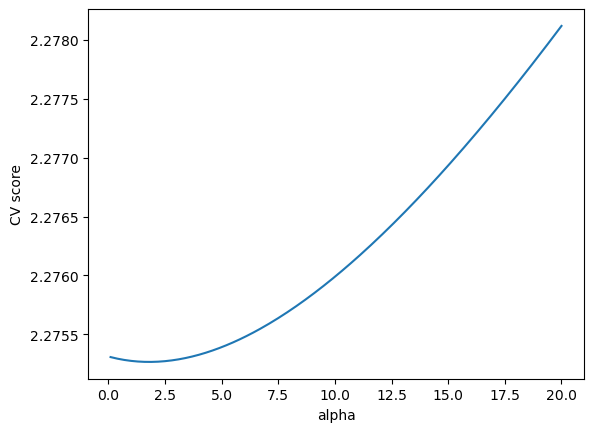

In [36]:
def ridge_search_params(model, param, data, target):

    searcher = GridSearchCV(model, [{"alpha": param}], scoring="neg_root_mean_squared_error", cv=5)
    searcher.fit(data, target)

    best_alpha = searcher.best_params_["alpha"]
    print("Best alpha = %.4f" % best_alpha)

    plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
    plt.xlabel("alpha")
    plt.ylabel("CV score")
    
    return searcher.best_estimator_
    
alphas = np.arange(0.1, 20.1, 0.1)

best_ridge = ridge_search_params(model_ridge, alphas, X_train, y_train)
best_ridge.fit(X_train, y_train)
ridge_preds = best_ridge.predict(X_test)

print("Test Ridge RMSE = %.4f" % mean_squared_error(y_test, ridge_preds, squared=False))
print("Test Ridge R2 = %.4f" % r2_score(y_test, ridge_preds))

Качество всех моделей улучшилось благодаря подбору гиперпараметров.

### 3. Добавление категориальных признаков

In [40]:
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_cat, y, test_size=0.25, random_state=42)

print(f"X_train: {X_trainc.shape} \ny_train: {y_trainc.shape} \nX_val: {X_testc.shape}, \ny_val: {y_testc.shape}")

X_train: (3132, 11) 
y_train: (3132,) 
X_val: (1045, 11), 
y_val: (1045,)


Заново подберем гиперпараметры для моделей

Best params:  {'n_neighbors': 18, 'p': 2, 'weights': 'distance'}
Best alpha = 1.8000
Test KNN RMSE = 2.1850
Test KNN R2 = 0.5359
Test Ridge RMSE = 2.2011
Test Ridge R2 = 0.5291


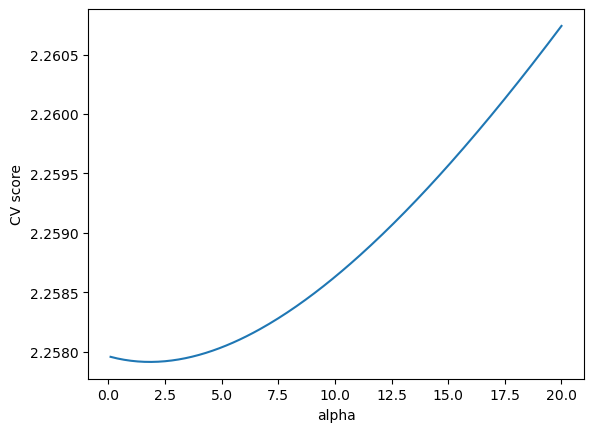

In [43]:
best_knn = knn_search_params(model_knn, params, X_trainc, y_trainc)
best_knn.fit(X_trainc, y_trainc)
knn_preds = best_knn.predict(X_testc)

best_ridge = ridge_search_params(model_ridge, alphas, X_trainc, y_trainc)
best_ridge.fit(X_trainc, y_trainc)
ridge_preds = best_ridge.predict(X_testc)

print("Test KNN RMSE = %.4f" % mean_squared_error(y_testc, knn_preds, squared=False))
print("Test KNN R2 = %.4f" % r2_score(y_test, knn_preds))

print("Test Ridge RMSE = %.4f" % mean_squared_error(y_testc, ridge_preds, squared=False))
print("Test Ridge R2 = %.4f" % r2_score(y_test, ridge_preds))

Несмотря на то, что категориальный признак только 1, получилось немного улучшить качество модели

Подберем гиперпараметры для *Random Forest* с помощью библиотеки *optuna*

In [53]:
import optuna

def objective(trial):

    param = {
        "max_depth" : trial.suggest_int('max_depth', 10, 25),
        "max_features" : trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 20),
        "n_estimators" :  trial.suggest_int('n_estimators', 30, 1000)
    }

    model_rf = RandomForestRegressor(**param, verbose=False, random_state=41)

    score = cross_val_score(model_rf, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2023-07-28 19:49:22,462] A new study created in memory with name: no-name-710eeea7-3895-472e-9eef-de77c9edc870
[I 2023-07-28 19:49:26,687] Trial 0 finished with value: -2.205409791578808 and parameters: {'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'n_estimators': 325}. Best is trial 0 with value: -2.205409791578808.
[I 2023-07-28 19:49:30,418] Trial 1 finished with value: -2.1691941721784502 and parameters: {'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 234}. Best is trial 1 with value: -2.1691941721784502.
[I 2023-07-28 19:49:31,255] Trial 2 finished with value: -2.1878481595584867 and parameters: {'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 59}. Best is trial 1 with value: -2.1691941721784502.
[I 2023-07-28 19:49:41,645] Trial 3 finished with value: -2.2036484226655286 and parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'n_estimators': 761}. Best is trial 1 with

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
[I 2

[I 2023-07-28 19:53:36,777] Trial 18 finished with value: -2.1594928177132893 and parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 668}. Best is trial 18 with value: -2.1594928177132893.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'`

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
[I 2023-07-28 19:56:02,081] Trial 24 finished with value: -2.1580899705806837 and parameters: {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 7, 'n_estimators': 749}. Best is trial 21 with value: -2.15732014813614.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` ha

[I 2023-07-28 19:58:49,178] Trial 31 finished with value: -2.1580520642112724 and parameters: {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 7, 'n_estimators': 744}. Best is trial 21 with value: -2.15732014813614.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` ha

[I 2023-07-28 20:01:39,018] Trial 40 finished with value: -2.163141045776846 and parameters: {'max_depth': 23, 'max_features': 'auto', 'min_samples_leaf': 13, 'n_estimators': 934}. Best is trial 21 with value: -2.15732014813614.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` ha

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
[I 2023-07-28 20:04:07,173] Trial 47 finished with value: -2.1746063983151287 and parameters: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 455}. Best is trial 21 with value: -2.15732014813614.
`max_features='auto'` ha

FrozenTrial(number=21, state=TrialState.COMPLETE, values=[-2.15732014813614], datetime_start=datetime.datetime(2023, 7, 28, 19, 54, 21, 10099), datetime_complete=datetime.datetime(2023, 7, 28, 19, 54, 44, 807196), params={'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 6, 'n_estimators': 716}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=25, log=False, low=10, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=30, step=1)}, trial_id=21, value=None)


In [57]:
best_rf = RandomForestRegressor(verbose=False, max_depth=10, max_features=1.0,
                                min_samples_leaf=6, n_estimators=716)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

print("Test RandomForest RMSE = %.4f" % mean_squared_error(y_test, rf_preds, squared=False))
print("Test RandomForest R2 = %.4f" % r2_score(y_test, rf_preds))

Test RandomForest RMSE = 2.1510
Test RandomForest R2 = 0.5502


### 4-5. Анализ значимости признаков и объяснимости прогнозов

визуализируем веса, соответствующие признакам для Ridge модели и посмотрим какие признаки чаще всего использует случайный лес в предикатах. 

In [44]:
def show_weights(features, weights):
    fig = plt.subplots(figsize=(14, 10))
    sorted_weights = sorted(zip(weights, features), reverse=True)
    weights, features = zip(*sorted_weights)
    features = list(features)
    sns.barplot(y=features, x=list(weights))

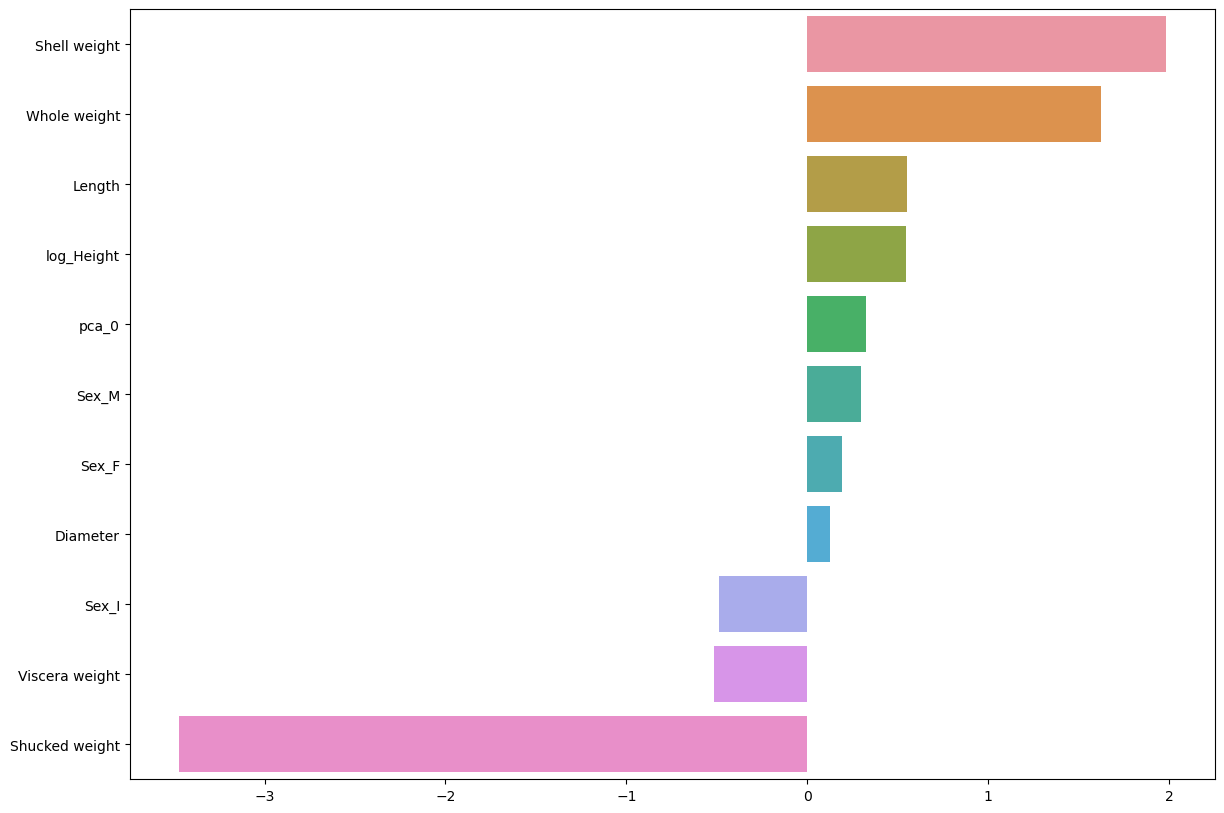

In [47]:
show_weights(X_trainc.columns, best_ridge.coef_)

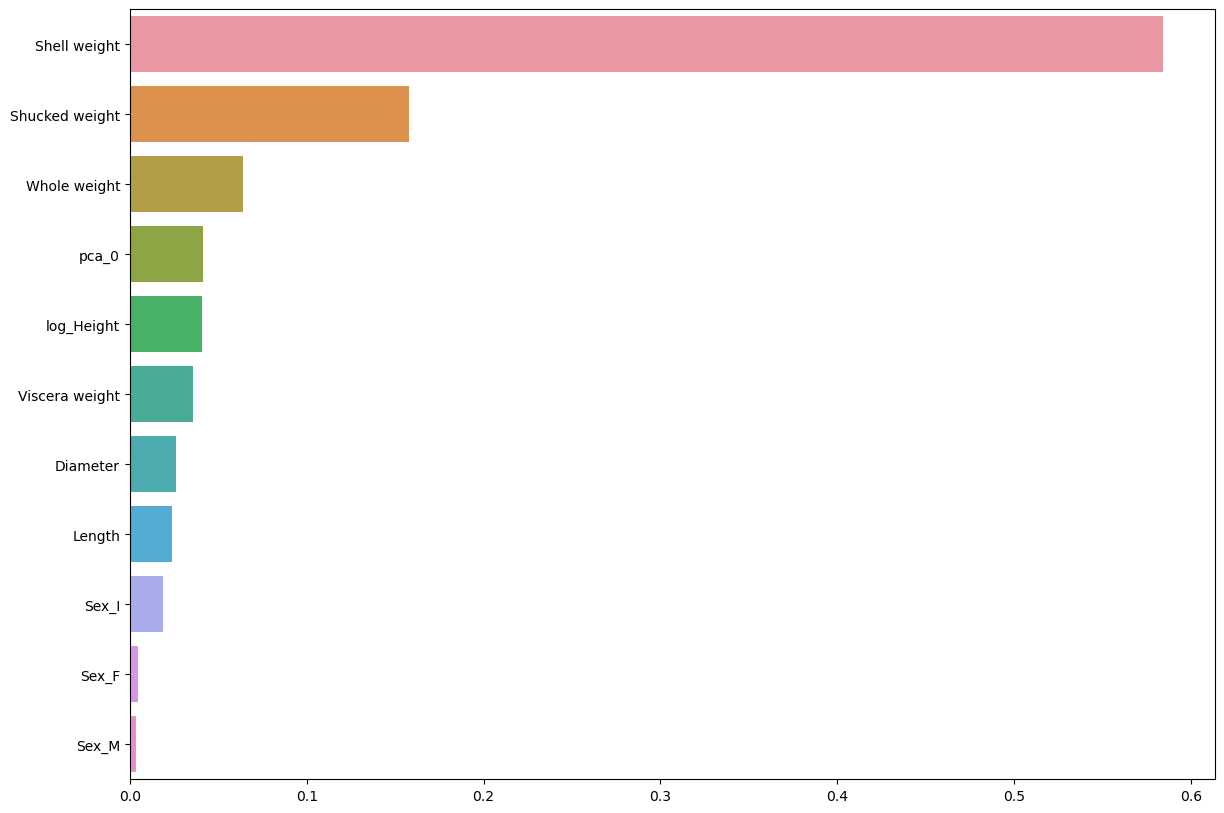

In [65]:
show_weights(X_train.columns, best_rf.feature_importances_)

Для обеих моделей признаки *Shell weight* и *Shucked weight* имеют наибольшее значение. В случае линейной модели они дают больший вклад в ответ, в случае случайного леса чаще всего используются в предикатах для разделения выборки.

используем SHAPE для визуализации того, как модель на самом деле использует каждую функцию для составления прогнозов.

In [67]:
explainer = shap.TreeExplainer(best_rf) 
shap_values = explainer.shap_values(X_test)

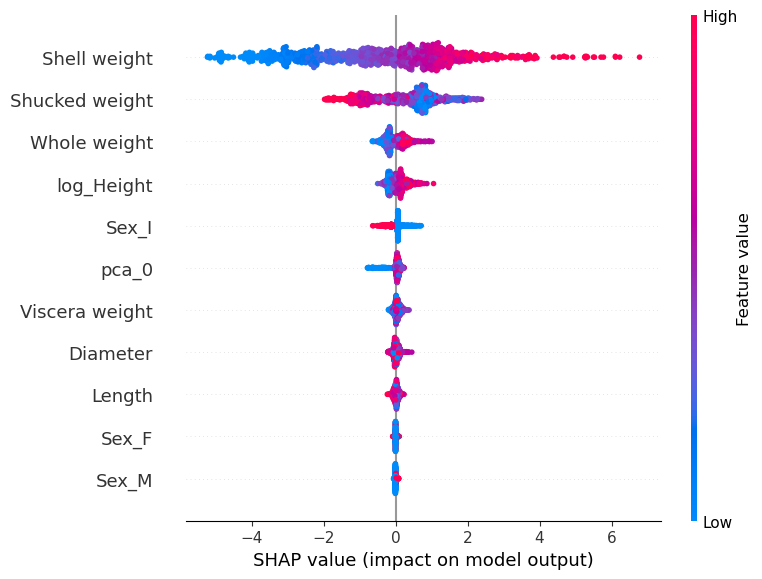

In [69]:
shap.summary_plot(shap_values, X_test);

С точки зрения SHAP value признаки *Shell weight* и *Shucked weight* самые важные

In [70]:
shap.initjs()

print('Correct answer:', y_test.iloc[2])
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

Correct answer: 16


Проинтерпретируем индивидуальный прогноз модели: наибольший вклад вносят признаки *Shell weight*
и *Shucked weight*, прогноз отличается от base value в большую сторону

Построим Explainer Dashboard

In [75]:
explainer = RegressionExplainer(best_rf, X_test, y_test)
db = ExplainerDashboard(explainer)
db.run();

Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explaine

В среднем для значения прогноза важны следующие признаки: *Shell weight*, *Shucked weight*, *Whole weight*
R2 = 0.55 (0 если модель предсказывает среднее, 1 если модель все предсказала правильно)

Проинтерпретируем объект с индексом 14: предсказано - 10.5, действительное значение - 10. Значительный вклад в прогноз внесли признаки *log_Height* и *Whole weight* и то, что это не детеныш

Проинтерпретируем объект с индексом 2016: предсказано - 10.5, действительное значение - 10. Значительный вклад в прогноз внесли признаки *Shell weight* и *Whole weight*. Убеждаемся, что для модели в принципе безразличен пол, важно лишь, что это детеныш или нет.